--- Analyzing FD001 ---
Shape: (16527, 25)
Constant columns (Variance=0): ['op3', 's1', 's18', 's19']


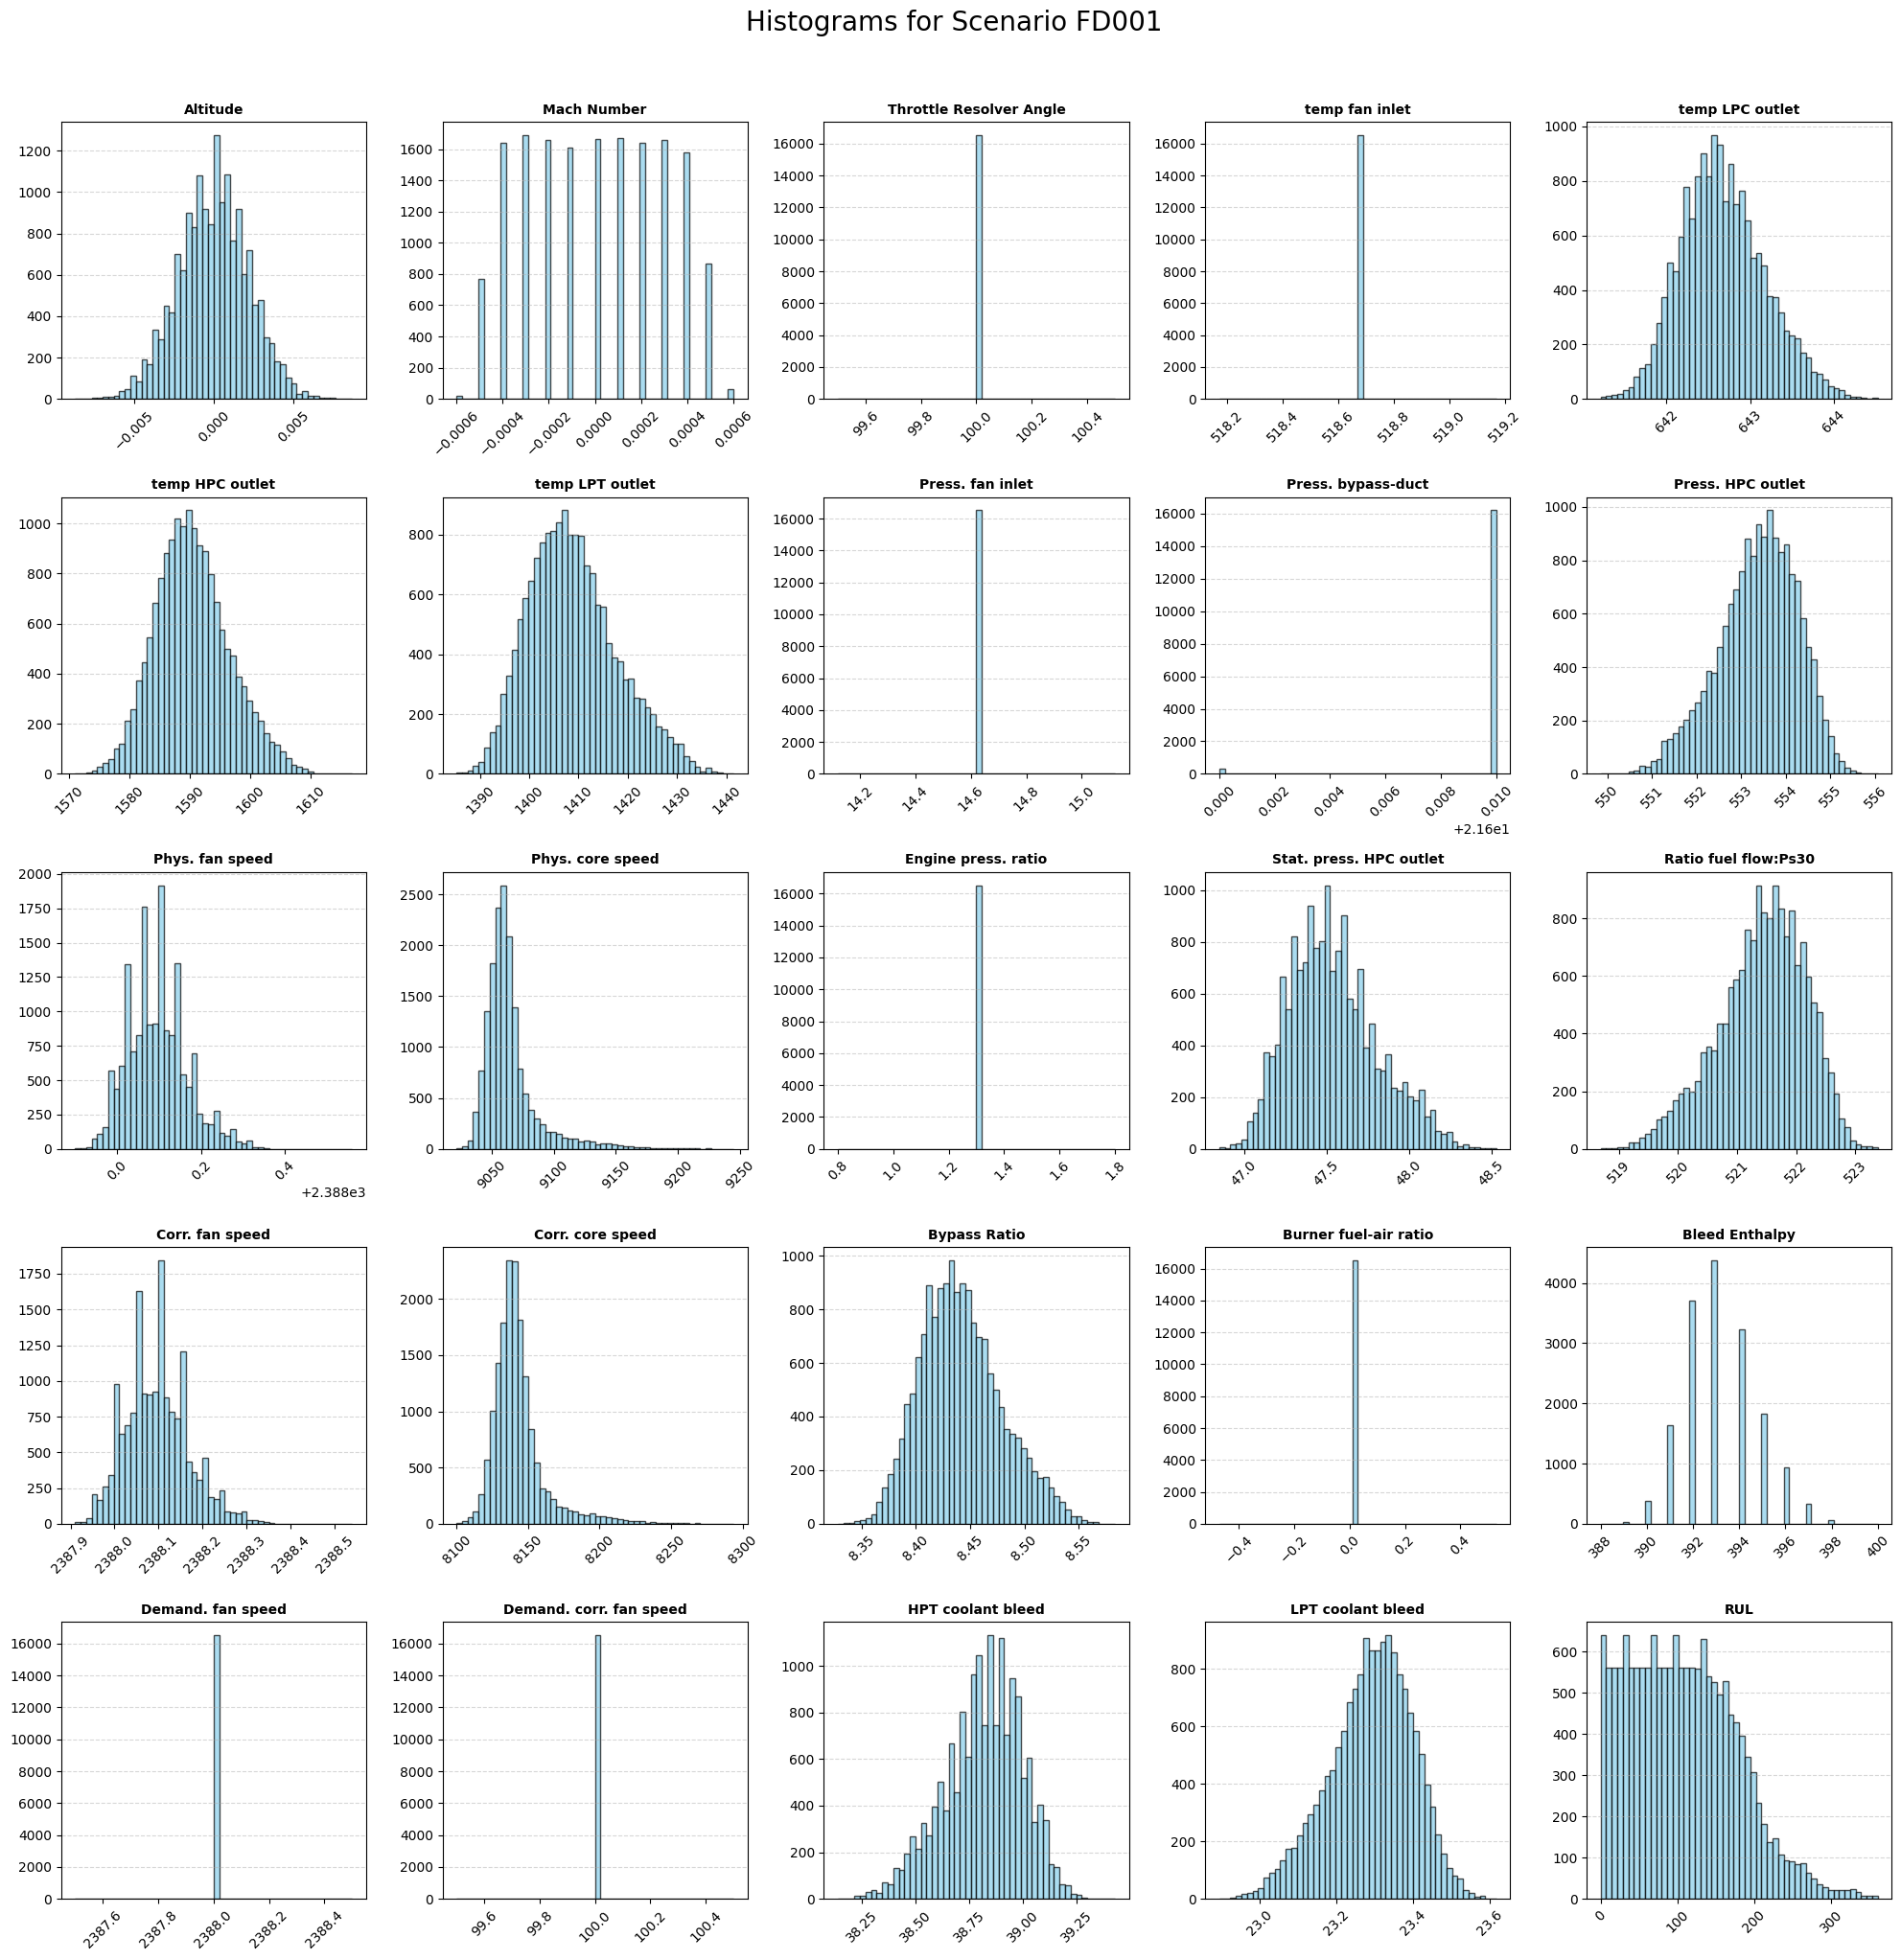

--- Analyzing FD002 ---
Shape: (43301, 25)
No constant columns found.


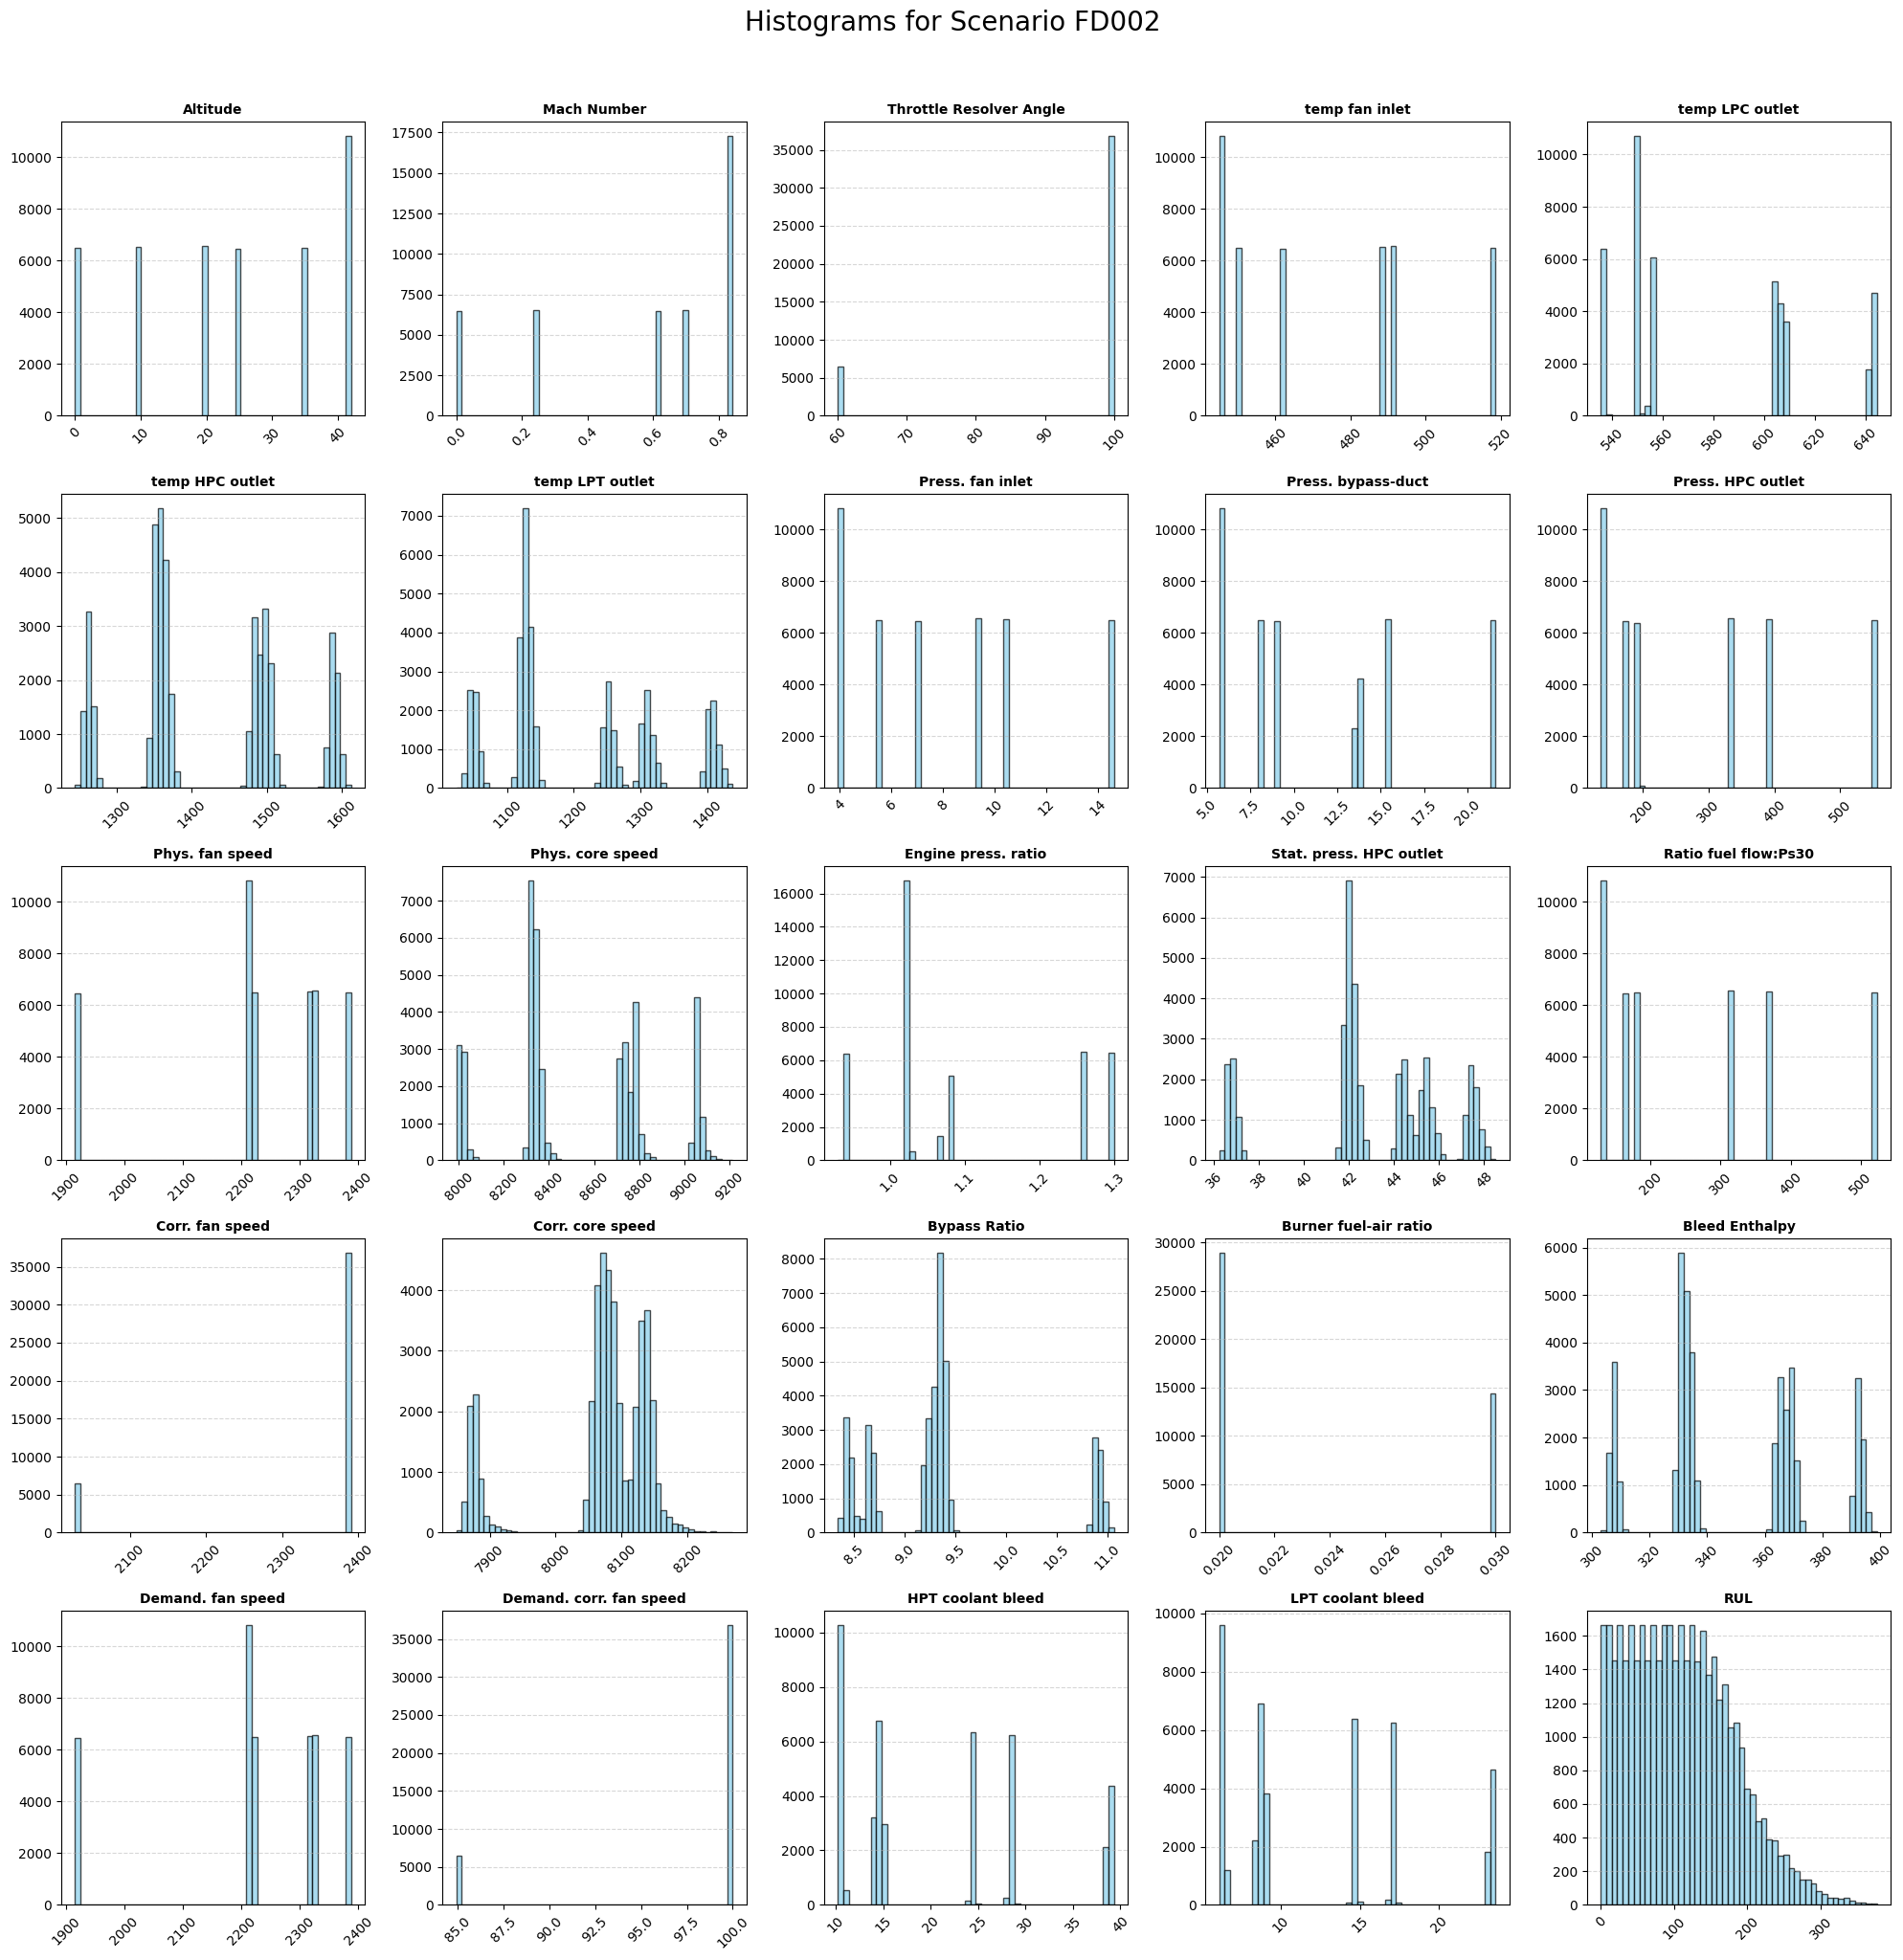

--- Analyzing FD003 ---
Shape: (19842, 25)
Constant columns (Variance=0): ['op3', 's16', 's18', 's19']


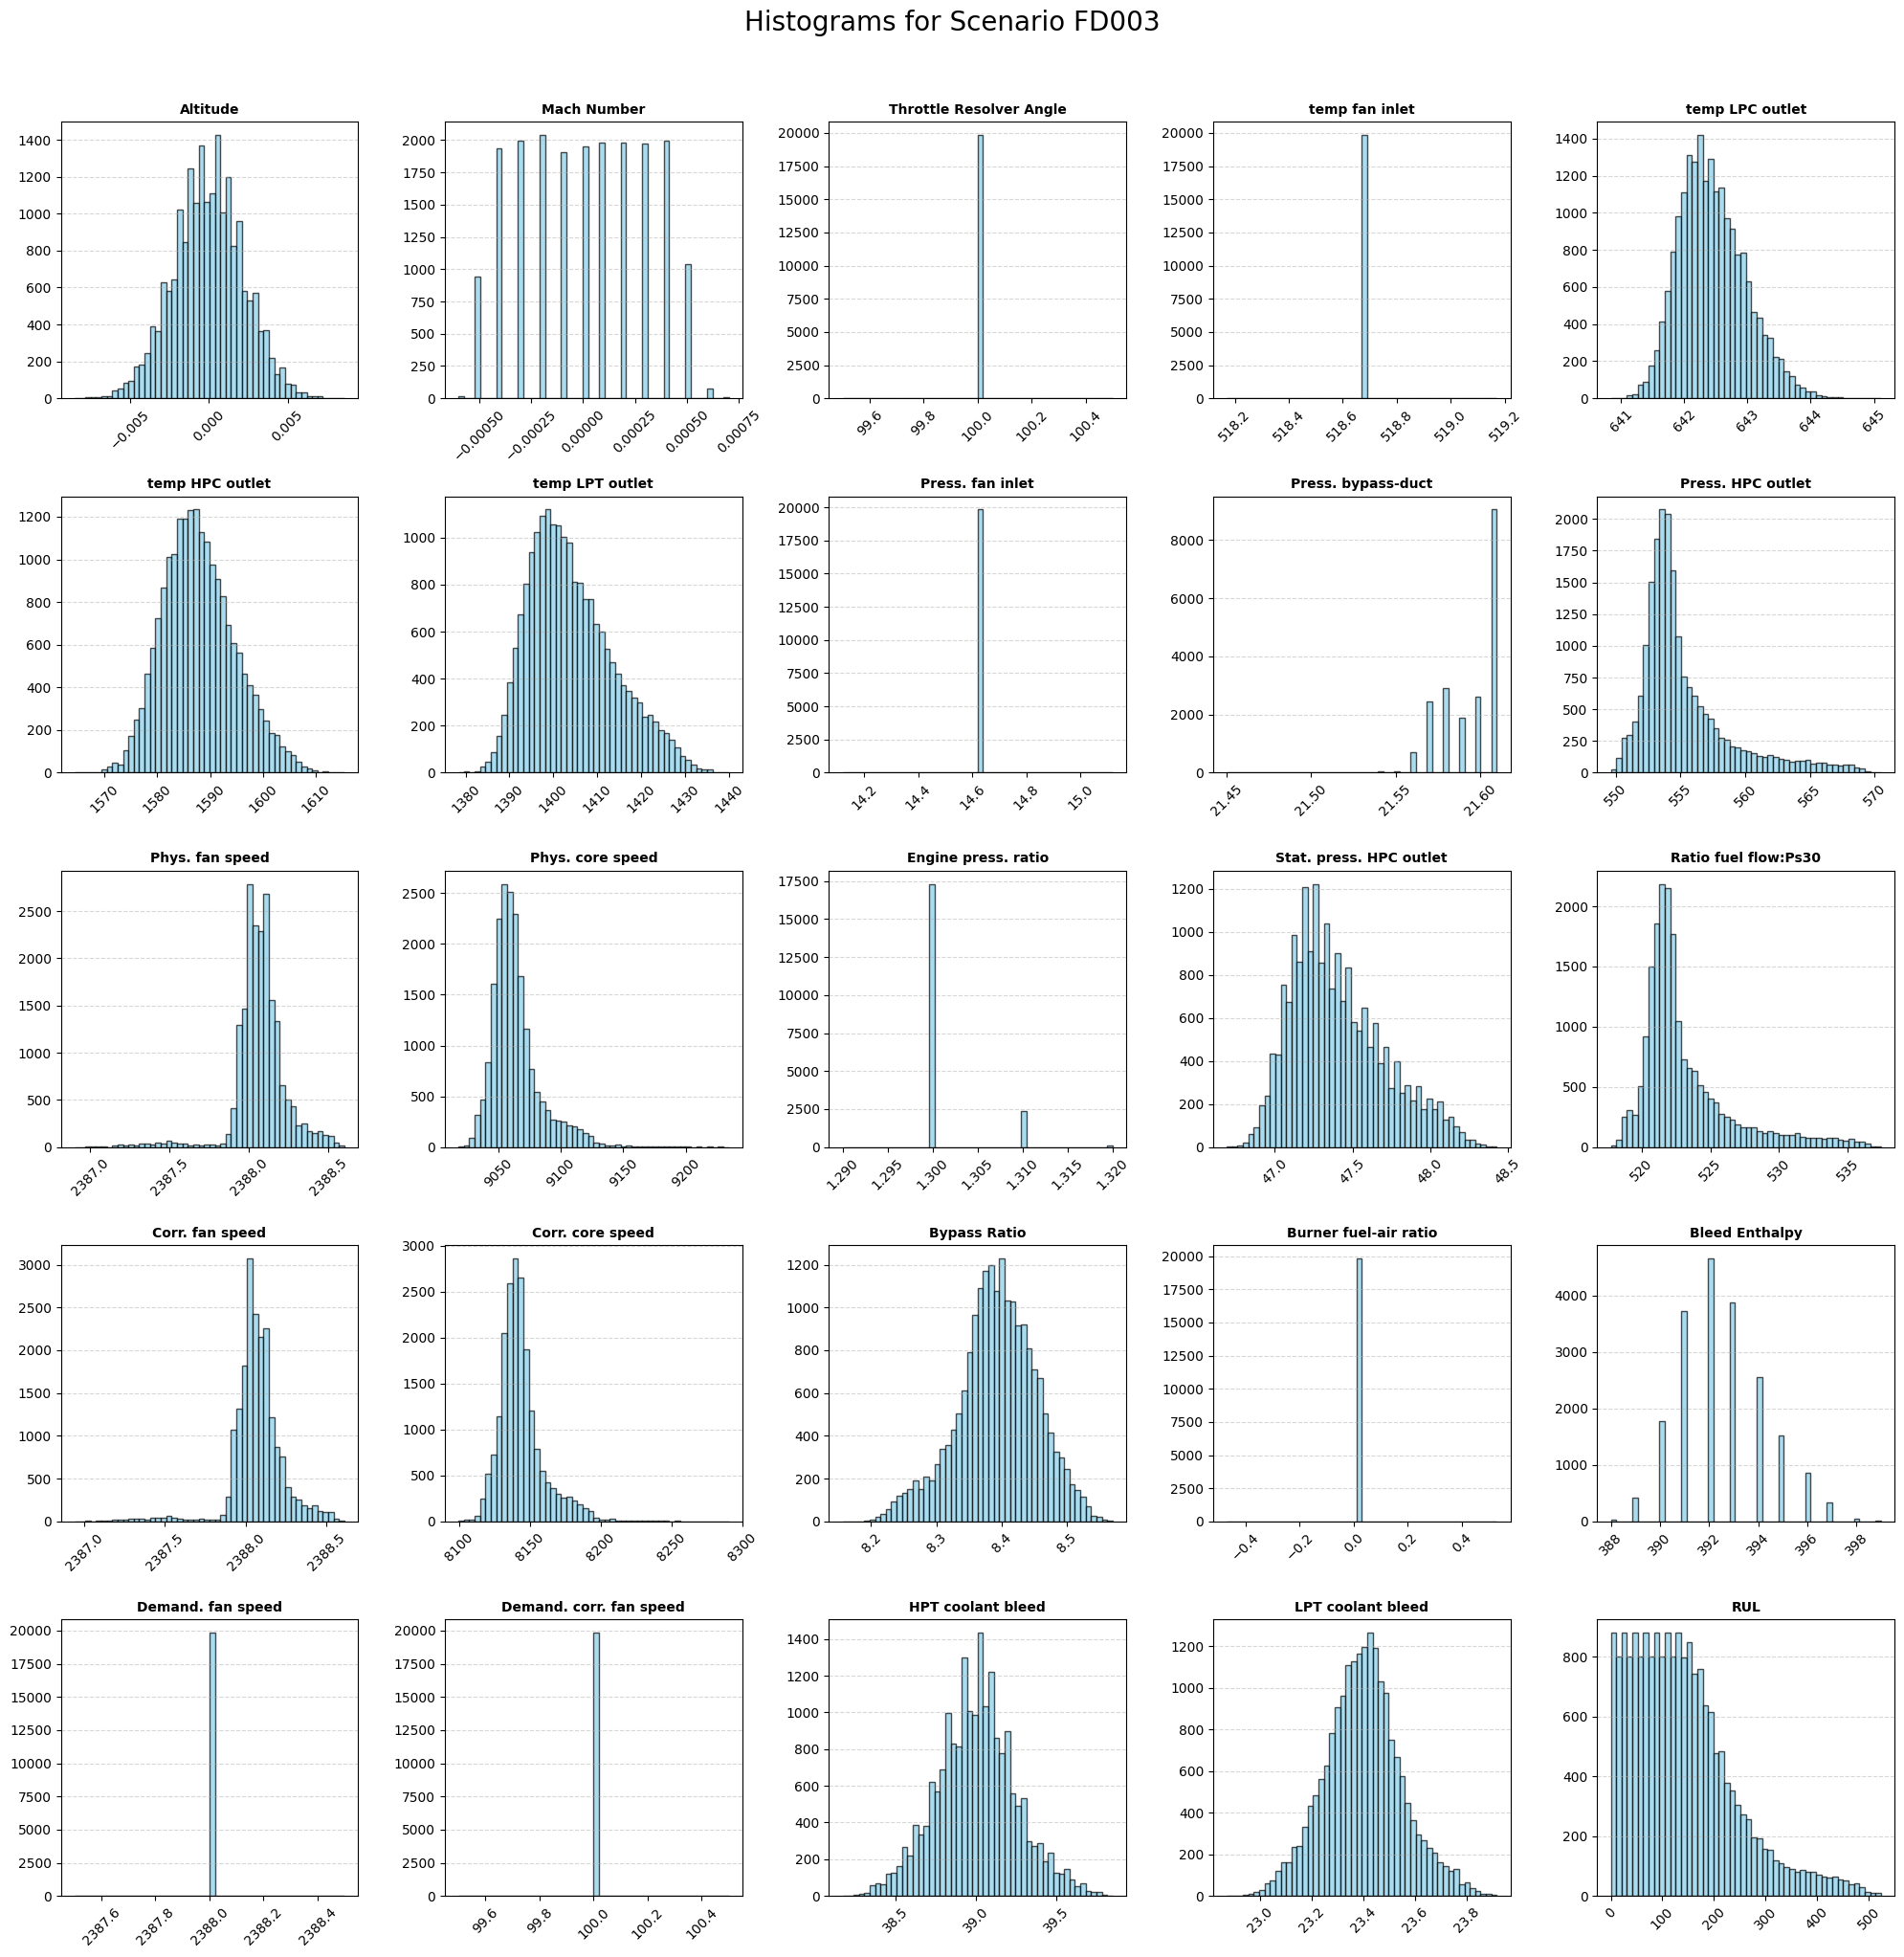

--- Analyzing FD004 ---
Shape: (49521, 25)
No constant columns found.


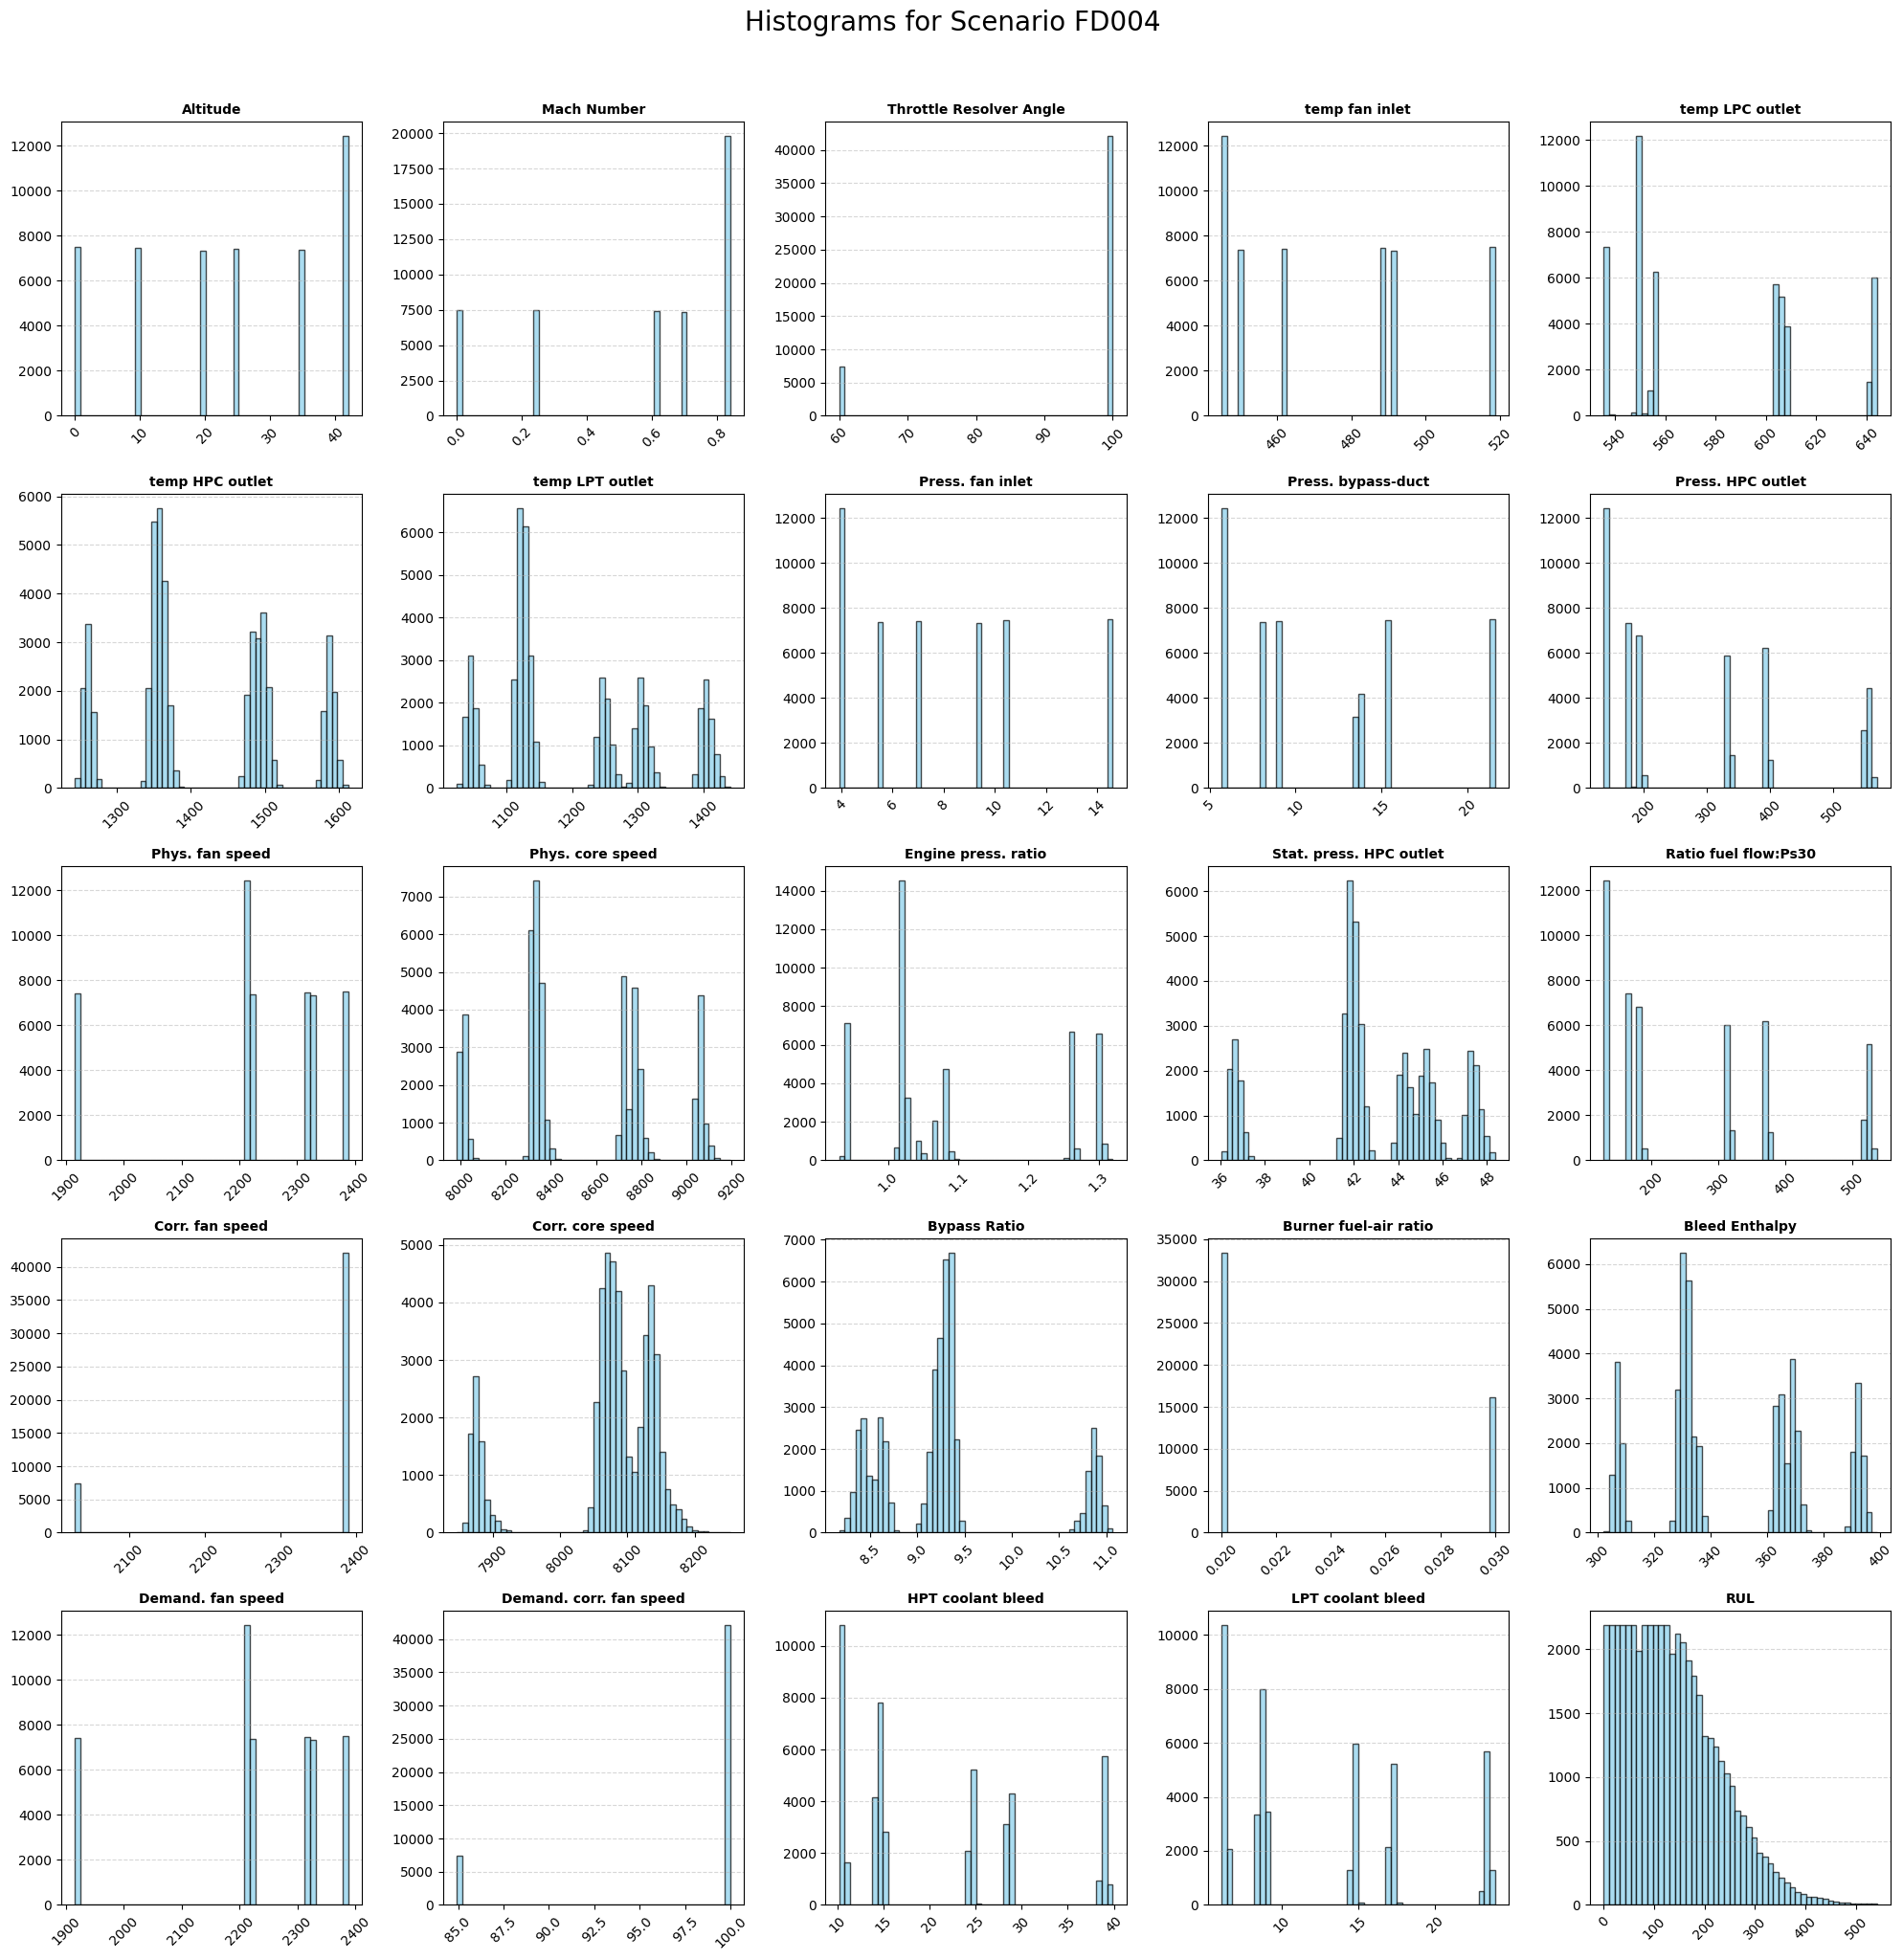

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import math

# --- Configuration ---
DATA_BASE_DIR = '../data/scenarios_train-only'
SCENARIOS = ['FD001', 'FD002', 'FD003', 'FD004']

def load_scenario_data(scenario_name):
    """Loads the csv and json metadata for a given scenario."""
    folder_path = os.path.join(DATA_BASE_DIR, scenario_name)
    
    # Construct file paths
    csv_filename = f"train_{scenario_name}.csv"
    csv_path = os.path.join(folder_path, csv_filename)
    json_path = os.path.join(folder_path, "info.json")
    
    # Load Data
    if not os.path.exists(csv_path) or not os.path.exists(json_path):
        print(f"Warning: Files not found for {scenario_name} at {folder_path}")
        return None, None
        
    df = pd.read_csv(csv_path)
    
    with open(json_path, 'r') as f:
        metadata = json.load(f)
        
    return df, metadata

def plot_histograms(df, metadata, scenario_name):
    """Plots histograms for all columns using metadata descriptions."""
    
    # Get all columns except maybe RUL if you want to treat it separately, 
    # but usually RUL distribution is interesting too. We include all.
    columns = df.columns
    num_cols = len(columns)
    
    # Calculate grid dimensions (approx square)
    n_cols_plot = 5
    n_rows_plot = math.ceil(num_cols / n_cols_plot)
    
    fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(20, 4 * n_rows_plot))
    fig.suptitle(f"Histograms for Scenario {scenario_name}", fontsize=20, y=1.02)
    
    # Flatten axes for easy iteration
    axes = axes.flatten()
    
    # Extract column metadata map
    col_meta_map = metadata.get('column_metadata', {})
    
    for i, col_name in enumerate(columns):
        ax = axes[i]
        
        # Plot Histogram
        ax.hist(df[col_name], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
        
        # Get Short Description
        # Fallback to column name if metadata is missing
        col_info = col_meta_map.get(col_name, {})
        title_text = col_info.get('short_description', col_name)
        
        # If it's an Op setting or RUL, the key might be slightly different in your JSON
        # checking the fallback:
        if col_name.startswith("op"):
             # In previous steps op1 didn't have 'short_description', just 'description'
             title_text = col_info.get('description', col_name)
        if col_name == "RUL":
             title_text = "RUL"

        ax.set_title(title_text, fontsize=10, fontweight='bold')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', linestyle='--', alpha=0.5)

    # Turn off unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.show()

# --- Execution ---

for scenario in SCENARIOS:
    print(f"--- Analyzing {scenario} ---")
    df, meta = load_scenario_data(scenario)
    
    if df is not None:
        # Print basic stats to check for constant columns (std=0)
        print(f"Shape: {df.shape}")
        
        # Identify constant columns
        variances = df.var()
        constant_cols = variances[variances == 0].index.tolist()
        if constant_cols:
            print(f"Constant columns (Variance=0): {constant_cols}")
        else:
            print("No constant columns found.")
            
        plot_histograms(df, meta, scenario)